## Twitter sentiment analysis with BART Comparaison - Machine Learning models notebook

### Import librairies

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from spellchecker import SpellChecker

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")

[nltk_data] Downloading package punkt to /Users/photoli93/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/photoli93/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading data

In [2]:
file_path = "../data/dataset_twitter_classification.csv"

df = pd.read_csv(file_path)

display(df.sample(5))
print(df.info())
display(df.describe())

,is_positive,id,datetime,user,message,bart_is_positive,text_length,word_count,sentence_count,avg_word_length,punctuation_count,capital_letters_count,exclamation_count,question_count,url_count,mention_count,hashtag_count,bart_pred,clean_text
7851,1,2047483392,Fri Jun 05 13:43:11 PDT 2009,chelseablobs,Kris and Lisa = Housemates 3 &amp; 4 Yeyy,0.750379,42,9,1,3.666667,3,4,0,0,0,0,0,1,kris lisa housemates 3 amp 4 yeyy
8747,1,1989319265,Mon Jun 01 01:06:23 PDT 2009,gabba_,@VetrinaGirl seasoned corn ... it depends on ...,0.108295,72,12,3,5.000000,8,2,0,0,0,1,0,0,vetrinagirl seasoned corn depends stored
13147,1,2058332632,Sat Jun 06 14:43:44 PDT 2009,BonnieHoffman,Link: #Spud! http://tinyurl.com/46sd4p Cool!,0.932701,45,4,4,10.250000,9,3,2,0,1,0,1,1,link spud <URL> cool
16517,1,1822431498,Sat May 16 19:33:47 PDT 2009,Sunidlight,I i i i i i i i i i i i i i i lol &lt;+*throu...,0.038173,57,17,1,2.352941,8,2,0,0,0,0,0,0,lol lt throughgod gt
6470,1,2176486305,Mon Jun 15 04:00:19 PDT 2009,DrWho1975,is looking forward to a lovely eve ahead,0.969866,41,8,1,4.125000,0,0,0,0,0,0,0,1,looking forward lovely eve ahead


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   is_positive            20000 non-null  int64  
 1   id                     20000 non-null  int64  
 2   datetime               20000 non-null  object 
 3   user                   20000 non-null  object 
 4   message                20000 non-null  object 
 5   bart_is_positive       20000 non-null  float64
 6   text_length            20000 non-null  int64  
 7   word_count             20000 non-null  int64  
 8   sentence_count         20000 non-null  int64  
 9   avg_word_length        20000 non-null  float64
 10  punctuation_count      20000 non-null  int64  
 11  capital_letters_count  20000 non-null  int64  
 12  exclamation_count      20000 non-null  int64  
 13  question_count         20000 non-null  int64  
 14  url_count              20000 non-null  int64  
 15  me

,is_positive,id,bart_is_positive,text_length,word_count,sentence_count,avg_word_length,punctuation_count,capital_letters_count,exclamation_count,question_count,url_count,mention_count,hashtag_count,bart_pred
count,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.00000
mean,0.502900,1.999831e+09,0.308301,74.321800,13.209500,2.354150,4.868268,4.006500,3.266950,0.573750,0.15770,0.044100,0.493950,0.026250,0.30550
std,0.500004,1.938426e+08,0.353417,36.389079,6.952138,1.232357,1.350713,3.487702,5.251816,1.405119,1.08724,0.210374,0.595215,0.182654,0.46063
min,0.000000,1.467816e+09,0.000089,7.000000,1.000000,1.000000,1.428571,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,1.957074e+09,0.004287,44.000000,7.000000,1.000000,4.090909,2.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,2.002057e+09,0.110693,70.000000,12.000000,2.000000,4.600000,3.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,2.177694e+09,0.638163,104.000000,19.000000,3.000000,5.285714,6.000000,4.000000,1.000000,0.00000,0.000000,1.000000,0.000000,1.00000
max,1.000000,2.329179e+09,0.998371,222.000000,41.000000,21.000000,45.333333,89.000000,105.000000,74.000000,88.00000,4.000000,9.000000,5.000000,1.00000


### Data Preprocessing

In [3]:
# Init
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

def remove_html_artefacts(text):
    """Remove HTML artefacts amp, lt, gt"""
    # On peut ajouter d'autres artefacts si besoin
    artifacts = ["amp", "lt", "gt"]
    pattern = r'\b(' + '|'.join(artifacts) + r')\b'
    return re.sub(pattern, '', text)

def correct_spelling(tokens):
    """Correct spelling for each token"""
    corrected_tokens = []
    for token in tokens:
        # Skip Twitter mentions and <URL>
        if token.startswith('@') or token == '':
            corrected_tokens.append(token)
        else:
            corrected_tokens.append(spell.correction(token))
    return corrected_tokens

def tokenize_and_process(text, use_stemming=True, remove_stopwords=True):
    """Tokenize text and apply stemming or lemmatization"""
    if not text:
        return ""

    # Remove contractions
    text = contractions.fix(text)
    
    # Remove HTML artefacts
    text = remove_html_artefacts(text)

    # Temporarily protect <URL> and <EMAIL>
    text = text.replace("<URL>", "URLTOKEN").replace("<EMAIL>", "EMAILTOKEN")

    # Tokenize texts
    tokens = word_tokenize(text)

    # Restore <URL> and <EMAIL> in tokens
    tokens = ["<URL>" if t == "URLTOKEN" else ("<EMAIL>" if t == "EMAILTOKEN" else t) for t in tokens]
    
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    if use_stemming:
        tokens = [stemmer.stem(token) for token in tokens]
    else:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

def preprocess(texts, use_stemming=True, remove_stopwords=True):
    """Apply full preprocessing pipeline to a list of texts"""
    return [
        tokenize_and_process(text, use_stemming, remove_stopwords)
        for text in texts
    ]

df['processed_text'] = preprocess(df['clean_text'].tolist(), use_stemming=False)

print("\n=== Preprocessing Examples ===")
for i, row in df.sample(5).iterrows():
    print(f"Original: {row['message']}")
    print(f"Processed: {row['processed_text']}")
    print("-" * 50)


=== Preprocessing Examples ===
Original: Went to the Golden EARS Bridge opening party today. We walked from end to end! Despite the *SEA* of people, it was pretty damn cool. 
Processed: went golden ear bridge opening party today walked end end despite sea people pretty damn cool
--------------------------------------------------
Original: @ash_punch i see mr robofillet saw what i said bout unfollowing him..oopsy. sorry mr robofillet 
Processed: ash_punch see mr robofillet saw said bout unfollowing oopsy sorry mr robofillet
--------------------------------------------------
Original: @MelissaEGilbert you have a book due out june 9th.... what is the title so i can be sure to get a copy? thanks  
Processed: melissaegilbert book due june 9th title sure get copy thanks
--------------------------------------------------
Original: @Ericka05 Thanks :-D I think I'm starting to figure it out now  Just took me a bit of getting used to!
Processed: ericka05 thanks think starting figure took bit ge

### Feature Engineering and Model Training

In [4]:
# Train_test_split
def prepare_features(df, test_size=0.2, random_state=42):
    """Prepare features and split data"""
    # Remove empty processed texts
    df_clean = df[df['processed_text'].str.len() > 0].copy()
    
    X = df_clean['processed_text']
    y = df_clean['is_positive']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Training set positive ratio: {y_train.mean():.3f}")
    print(f"Test set positive ratio: {y_test.mean():.3f}")
    
    return X_train, X_test, y_train, y_test, df_clean

X_train, X_test, y_train, y_test, df_clean = prepare_features(df)

Training set size: 15999
Test set size: 4000
Training set positive ratio: 0.503
Test set positive ratio: 0.503


In [5]:
# Define candidate models with pipelines to avoid data leakage
pipelines = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=15000, ngram_range=(1, 3), 
                                    min_df=3, max_df=0.7, stop_words='english')),
        ('clf', MultinomialNB(alpha=0.1))
    ]),

    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=15000, ngram_range=(1, 3), 
                                    min_df=3, max_df=0.7, stop_words='english')),
        ('clf', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=15000, ngram_range=(1, 3), 
                                    min_df=3, max_df=0.7, stop_words='english')),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}

# Define hyperparameter search
param_search = {
    'Naive Bayes': {
        'search': GridSearchCV,
        'params': {'clf__alpha': [0.1, 0.5, 1.0],
                   'clf__fit_prior': [True, False]},
        'cv': 5
    },
    'Logistic Regression': {
        'search': GridSearchCV,
        'params': {'clf__C': [0.01, 0.05, 0.1, 0.5, 1, 5],
                   'clf__penalty': ['l2']},
        'cv': 5
    },
    'Random Forest': {
        'search': RandomizedSearchCV,
        'params': {'clf__n_estimators': randint(100, 500),
                   'clf__max_depth': randint(5, 50),
                   'clf__max_features': ['sqrt', 'log2', None]},
        'cv': 5,
        'n_iter': 20,
        'random_state': 42
    }
}

# Main loop
cv_results = {}
final_results = {}

for name, pipe in pipelines.items():
    print(f"\nOptimizing {name}")
    start = time.time()
    
    search_args = param_search[name]['params']
    cv = param_search[name]['cv']
    
    if param_search[name]['search'] == GridSearchCV:
        search = GridSearchCV(pipe, search_args, cv=cv, scoring='f1', n_jobs=-1)
    else:
        search = RandomizedSearchCV(pipe, search_args, cv=cv, scoring='f1', n_jobs=-1,
                                    n_iter=param_search[name]['n_iter'], random_state=param_search[name]['random_state'])
    
    search.fit(X_train, y_train)
    best_pipe = search.best_estimator_
    duration = time.time() - start
    
    # Cross-validation scores on training set with best params
    scores = cross_val_score(best_pipe, X_train, y_train, cv=5, scoring='f1')
    cv_results[name] = (scores.mean(), scores.std(), duration)
    
    # Train and evaluate on test set
    best_pipe.fit(X_train, y_train)
    y_pred = best_pipe.predict(X_test)
    y_proba = best_pipe.predict_proba(X_test)[:, 1] if hasattr(best_pipe.named_steps['clf'], "predict_proba") else None
    
    final_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'cv_f1_mean': cv_results[name][0],
        'cv_f1_std': cv_results[name][1],
        'cv_time_sec': cv_results[name][2],
        'train_time_sec': duration,
        'best_params': search.best_params_
    }


# Display results
metrics_df = pd.DataFrame({
    name: {
        'Accuracy': f"{res['accuracy']:.4f}",
        'Precision': f"{res['precision']:.4f}",
        'Recall': f"{res['recall']:.4f}",
        'F1-Score': f"{res['f1']:.4f}",
        'ROC-AUC': f"{res['roc_auc']:.4f}" if res['roc_auc'] else "N/A",
        'CV F1 (μ±σ)': f"{res['cv_f1_mean']:.4f}±{res['cv_f1_std']:.4f}",
        'CV Time (s)': f"{res['cv_time_sec']:.2f}",
        'Train Time (s)': f"{res['train_time_sec']:.2f}"
    }
    for name, res in final_results.items()
}).T

print("\n=== Final Model Performance ===")
display(metrics_df)


Optimizing Naive Bayes

Optimizing Logistic Regression

Optimizing Random Forest

=== Final Model Performance ===


,Accuracy,Precision,Recall,F1-Score,ROC-AUC,CV F1 (μ±σ),CV Time (s),Train Time (s)
Naive Bayes,0.7272,0.7288,0.7291,0.7289,0.8000,0.7256±0.0089,3.42,3.42
Logistic Regression,0.7275,0.7223,0.7445,0.7332,0.8042,0.7260±0.0105,2.12,2.12
Random Forest,0.7340,0.7081,0.8017,0.7520,0.8017,0.7373±0.0076,170.27,170.27


### Model validation and Analysis

In [6]:
def detailed_model_analysis(pipelines, final_results, X_train, y_train, X_test, y_test, model_name=None, top_n_features=15):
    """
    Perform detailed analysis of a model.
    
    Parameters:
    - pipelines: dict of trained pipelines
    - final_results: dict with evaluation metrics
    - X_train, y_train, X_test, y_test: datasets
    - model_name: string, name of the model to analyze (if None, pick best F1)
    - top_n_features: number of top features to show
    """
    
    # Pick model
    if model_name is None:
        best_model_name = max(final_results.keys(), key=lambda x: final_results[x]['f1'])
    else:
        if model_name not in pipelines:
            raise ValueError(f"Model '{model_name}' not found in pipelines.")
        best_model_name = model_name
    
    print(f"\n=== Detailed Analysis for Model: {best_model_name} ===")
    
    best_pipe = pipelines[best_model_name]
    
    # Fit the pipeline
    best_pipe.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_pipe.predict(X_test)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # Feature importance
    clf = best_pipe.named_steps['clf']
    tfidf = best_pipe.named_steps['tfidf']
    
    importances = None
    if hasattr(clf, 'coef_'):  # For LR
        importances = np.abs(clf.coef_[0])
    elif hasattr(clf, 'feature_importances_'):  # For RF
        importances = clf.feature_importances_
    elif hasattr(clf, 'feature_log_prob_'):  # For NB
        importances = np.max(np.abs(clf.feature_log_prob_), axis=0)
    
    if importances is not None:
        feature_names = tfidf.get_feature_names_out()
        top_indices = np.argsort(importances)[-top_n_features:]
        axes[1].barh(range(len(top_indices)), importances[top_indices])
        axes[1].set_yticks(range(len(top_indices)))
        axes[1].set_yticklabels([feature_names[i] for i in top_indices])
        axes[1].set_title(f'Top {top_n_features} Features')
        axes[1].set_xlabel('Importance')
    else:
        axes[1].text(0.5, 0.5, 'Feature importance\nnot available', ha='center', va='center')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return best_model_name, y_pred



=== Detailed Analysis for Model: Random Forest ===

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1988
           1       0.69      0.75      0.72      2012

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000



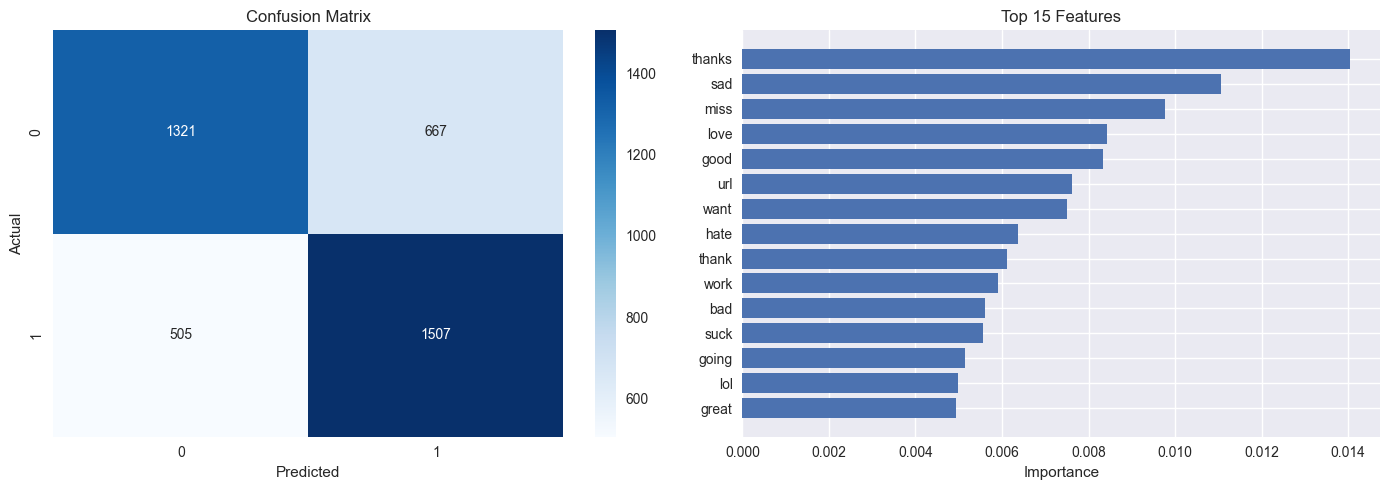


=== Detailed Analysis for Model: Logistic Regression ===

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1988
           1       0.72      0.74      0.73      2012

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



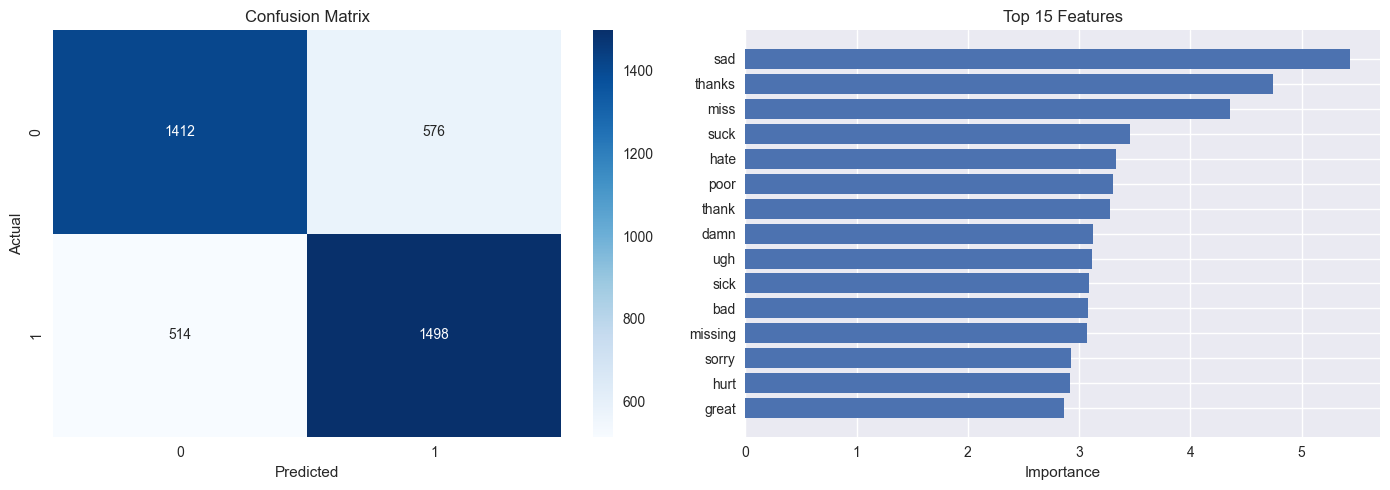

In [7]:
# Analyze the automatically picked best model
best_model_name, best_predictions = detailed_model_analysis(
    pipelines, final_results, X_train, y_train, X_test, y_test
)

# Manually pick Logistic Regression
lr_model_name, lr_predictions = detailed_model_analysis(
    pipelines, final_results, X_train, y_train, X_test, y_test, model_name='Logistic Regression'
)
